# Analyzing Tweets about Self-Driving Cars

- Mukunda Aithal


In [34]:
import re #regular expressions
import spacy #natural language processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

# Reading and cleaning the data

In [35]:
data = pd.read_csv('Twitter-sentiment-self-drive-DFE.csv', encoding_errors='ignore')
data = data.drop(columns = ['_unit_state', 'sentiment_gold','sentiment_gold_reason'])
data

,_unit_id,_golden,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,text
0,724227031,True,236,NaN,5,0.7579,10001,Two places I'd invest all my money if I could:...
1,724227032,True,231,NaN,5,0.8775,10002,Awesome! Google driverless cars will help the ...
2,724227033,True,233,NaN,2,0.6805,10003,If Google maps can't keep up with road constru...
3,724227034,True,240,NaN,2,0.8820,10004,Autonomous cars seem way overhyped given the t...
4,724227035,True,240,NaN,3,1.0000,10005,Just saw Google self-driving car on I-34. It w...
...,...,...,...,...,...,...,...,...
7151,726942339,True,65,NaN,not_relevant,0.5616,10073,Washington DC metro trains are all self-drivin...
7152,726942340,True,71,NaN,not_relevant,0.7293,10074,I think #DARPA works on autonomous drone techn...
7153,726942341,True,63,NaN,not_relevant,0.8854,10075,I love the idea of driving myself to the denti...
7154,726942342,True,67,NaN,not_relevant,0.8431,10076,Who likes cars these days? No me. Too expensiv...


# EDA

In [36]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_unit_id,7156.0,7.243474e+08,250674.176598,7.242270e+08,7.243229e+08,7.243247e+08,7.243265e+08,726942343.0
_trusted_judgments,7156.0,5.834405e+00,11.144930,1.000000e+00,3.000000e+00,4.000000e+00,8.000000e+00,241.0
sentiment:confidence,7156.0,7.746541e-01,0.205363,2.480000e-01,6.306000e-01,7.531000e-01,1.000000e+00,1.0
our_id,7156.0,3.609931e+03,2140.401611,1.000000e+00,1.789750e+03,3.578500e+03,5.367250e+03,10077.0


In [37]:
data.isnull().sum()

_unit_id                 0
_golden                  0
_trusted_judgments       0
_last_judgment_at       77
sentiment                0
sentiment:confidence     0
our_id                   0
text                     0
dtype: int64

There are only 77 missing cells. All of which are in the _last_judgement_at column. This constitutes around 0.1% of the data so we should be good to remove those rows completetly. However we should check what those rows are to see if there is a reason why they are missing values.

In [38]:
na_df = data[data['_last_judgment_at'].isna()]
na_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_unit_id,77.0,7.265544e+08,956378.694668,7.242270e+08,7.269423e+08,7.269423e+08,7.269423e+08,726942343.0
_trusted_judgments,77.0,9.207792e+01,60.396664,1.000000e+00,6.500000e+01,7.200000e+01,7.800000e+01,241.0
sentiment:confidence,77.0,7.646701e-01,0.162950,4.552000e-01,6.363000e-01,7.704000e-01,8.866000e-01,1.0
our_id,77.0,1.003900e+04,22.371857,1.000100e+04,1.002000e+04,1.003900e+04,1.005800e+04,10077.0


In [39]:
data._last_judgment_at.unique()

array([nan, '5/21/15 0:44', '5/21/15 2:47', ..., '6/6/15 23:29',
       '5/24/15 14:28', '5/28/15 4:59'], dtype=object)

It seems like the data in this column is dates objects which is not relevant to what we need. Therefore, we can just drop the column.

In [40]:
data = data.drop(columns = ['_last_judgment_at'])

In [41]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data)
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

From this analysis we can get some insight:
- _golden almost only contains "False" values. This will not matter for now.

- _trusted_judgments has a mean of 5.834404695 with a standard deviation of 11.14493031. The most common values are 3, 8, 4, and 7 by a large amount.

- sentiment, which will be our y_train, is centered around a score of 3. This might cause issues with prediction with an over prediction of tweets with a score of 3 compared to other scores. There are 213 values labeled not_relevant which we may have to discard since they will not be relevant for prediction.  

- sentiment:confidence has clusters around 1, 0.7 to 0.8, 0.6 to 0.65, 0.5, and 0.35 to 0.4. But most of the values are 1 which means that 2705 out of the 7156 values have 100% confidence of the predictied sentiment. 

In [42]:
data = data[data['sentiment'] != 'not_relevant']
data.sentiment.unique()

array(['5', '2', '3', '1', '4'], dtype=object)

# Preparing the Data

This will tokenize the tweets and remove stop words as well as words that are very related to self-driving cars and will not add any value to analyzing sentiment.

In [43]:
tknzr= TweetTokenizer()
tweets = data['text']
nlp= spacy.load('en_core_web_sm')
cleaned_tweets= []
t_tokenizer= TweetTokenizer()
word_list = ['@google','google\'s','...','self-driving cars','car', 'cars', 'self', '#', 'driverless', 'vehicle', 'vehicles', 'drivers', 'driving', 'drive', 'autonomous', 'self-driving','word', 'google']
for tw in tweets:
    cleaned = [word for word in t_tokenizer.tokenize(tw.lower()) 
               if word not in nlp.Defaults.stop_words and len(word) > 2 and word not in word_list]
    cleaned_tweets.append(' '.join(cleaned))
    
len(cleaned_tweets)

6943

In [44]:
cleaned_tweets

["places i'd invest money printing",
 'awesome help blind travel https://t.co/qwuxr0frbpv',
 "maps can't road construction supposed trust",
 'way overhyped given technology challenges pilotless planes doable needed',
 'saw painted green blue',
 'eventually replace taxi cities',
 "reduce traffic fatalities i'm",
 "worth risk don't want highway server crashes #sadmacface #bluescreenofdeath",
 'legal florida california michigan',
 'audi carmaker license nevada dmv test automated #audi #ces #cartech',
 "audi says manufacturer world license nevada dmv test doesn't #ces",
 'future buying @cnet audi ready test public roads http://t.co/aztbhlcy #ces #2013ces̢',
 'audi test tampa today pretty cool',
 'audi automaker california test @latimes @audi #selfdrivingcars http://t.co/wyscaloqef',
 '@latimesautos audi gets permit test california roads http://t.co/l71qpm42ly http://t.co/cwbboawahl̢ ̡_̡',
 'audi gets permit test california http://t.co/jkdtjsupwa',
 "audi mercedes california's test permits 

There seem to be some url links in some of the tweets that should be removed. 

In [45]:
import re
cleaned_tweets2 = []
for tweet in cleaned_tweets:
    tweet = re.sub(r'https?://\S+', '', tweet)
    tweet = tweet.replace('#', '')
    cleaned_tweets2.append(tweet)
    
cleaned_tweets2

["places i'd invest money printing",
 'awesome help blind travel ',
 "maps can't road construction supposed trust",
 'way overhyped given technology challenges pilotless planes doable needed',
 'saw painted green blue',
 'eventually replace taxi cities',
 "reduce traffic fatalities i'm",
 "worth risk don't want highway server crashes sadmacface bluescreenofdeath",
 'legal florida california michigan',
 'audi carmaker license nevada dmv test automated audi ces cartech',
 "audi says manufacturer world license nevada dmv test doesn't ces",
 'future buying @cnet audi ready test public roads  ces 2013ces̢',
 'audi test tampa today pretty cool',
 'audi automaker california test @latimes @audi selfdrivingcars ',
 '@latimesautos audi gets permit test california roads   ̡_̡',
 'audi gets permit test california ',
 "audi mercedes california's test permits soon ",
 'audi gets permit test california bay area drag queens ',
 'today state regs effect audi america gets 1st permit test public roads @c

Word Count and POS Tagging

In [46]:
adjs = Counter()
nouns = Counter()
verbs = Counter()
for tw in cleaned_tweets2:
    for token in nlp(tw.lower()):    
        if token.text in nlp.Defaults.stop_words: # remove stop words
            continue
        if token.pos_ == 'ADJ':
            adjs[token.text] += 1
        elif token.pos_ == 'NOUN':
            nouns[token.text] += 1
        elif token.pos_ == 'VERB':
            verbs[token.text] += 1

In [47]:
print('MOST COMMON WORDS')
print('_________________')
print('Adjectives')
print(adjs.most_common(10))
print('_________________')
print('Nouns')
print(nouns.most_common(10))
print('_________________')
print('Verbs')
print(verbs.most_common(10))
print('_________________')

MOST COMMON WORDS
_________________
Adjectives
[('new', 214), ('future', 193), ('cool', 95), ('ready', 87), ('good', 85), ('great', 82), ('public', 69), ('awesome', 65), ('legal', 63), ('interesting', 63)]
_________________
Nouns
[('uber', 195), ('driver', 192), ('road', 161), ('today', 157), ('people', 154), ('wheel', 146), ('technology', 139), ('time', 131), ('future', 128), ('tech', 126)]
_________________
Verbs
[('saw', 283), ('think', 178), ('want', 164), ('going', 126), ('need', 122), ('says', 120), ('wait', 117), ('look', 92), ('coming', 84), ('come', 76)]
_________________


Lemmatizing

In [48]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()
cleaned_tweets3 = []

for tw in cleaned_tweets2:
    cleaned_tweets3.append(" ".join([lemma.lemmatize(i) for i in tw.split()]))
        

len(cleaned_tweets3)

[nltk_data] Downloading package wordnet to /Users/mukunda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


6943

In [49]:
cleaned_tweets3

["place i'd invest money printing",
 'awesome help blind travel',
 "map can't road construction supposed trust",
 'way overhyped given technology challenge pilotless plane doable needed',
 'saw painted green blue',
 'eventually replace taxi city',
 "reduce traffic fatality i'm",
 "worth risk don't want highway server crash sadmacface bluescreenofdeath",
 'legal florida california michigan',
 'audi carmaker license nevada dmv test automated audi ce cartech',
 "audi say manufacturer world license nevada dmv test doesn't ce",
 'future buying @cnet audi ready test public road ce 2013ces̢',
 'audi test tampa today pretty cool',
 'audi automaker california test @latimes @audi selfdrivingcars',
 '@latimesautos audi get permit test california road ̡_̡',
 'audi get permit test california',
 "audi mercedes california's test permit soon",
 'audi get permit test california bay area drag queen',
 'today state regs effect audi america get 1st permit test public road @ca_dmv',
 'audi get permit test 

Stemming (not used since we already lemmatized)

In [50]:
# from nltk.stem import SnowballStemmer
 
# st = SnowballStemmer("english")

# cleaned_tweets3 = []

# for tw in cleaned_tweets2:
#     cleaned_tweets3.append(" ".join([st.stem(i) for i in tw.split()]))

# len(cleaned_tweets3)

# Train Model

In [75]:
from sklearn.model_selection import train_test_split
truth = data['sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(cleaned_tweets3, truth, random_state=104, test_size=0.25, shuffle=True)


We will use the pretrained Vader model as a reference

In [52]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# sia = SentimentIntensityAnalyzer()

# def getSentimentScore(tweet): # takes ~30 min to run for all tweets
#     return sia.polarity_scores(tweet)['compound']
    
# scores = [getSentimentScore(cleaned_tweets3[i]) for i in range(len(cleaned_tweets3))]
# predictions = pd.cut(scores, bins=5, labels=[1, 2, 3, 4, 5])
# predictions

Training Multinomial Logistic Regression Model

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_train.shape

(5207, 8512)

In [58]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg')
model.fit(X_train, y_train)
prediction = model.predict(vectorizer.transform(X_test))
prediction
#scores = pd.cut(prediction, bins=5, labels=[1, 2, 3, 4, 5])

array(['5', '4', '5', ..., '4', '2', '4'], dtype=object)

In [67]:
column_names = ['cleaned_tweet', 'true_score', 'predicted_score']
results = pd.DataFrame(list(zip(X_test, y_test, prediction)), columns = column_names)
results['true_score'] = pd.to_numeric(results['true_score'])
results['predicted_score'] = pd.to_numeric(results['predicted_score'])

results

,cleaned_tweet,true_score,predicted_score
0,@barrier_trio like piss ppl comparing thing li...,1,5
1,need,4,4
2,wait reclaim wasted space parked wasted resour...,5,5
3,@inhabitat semi truck aka train,3,3
4,public sector train driver comp 100k striking ...,3,3
...,...,...,...
1731,auburn hill supplier's set hit nevada road con...,3,3
1732,launch fleet two-seater @latimes_driven,3,4
1733,hope right @fmanjoo amazing change video great,5,4
1734,@henebb barrier insurance liability who's caus...,2,2


## Top words in each predicted cateogry

In [68]:
score_5 = results[results['predicted_score'] == 5]
words_5 = Counter()
for tweet in score_5['cleaned_tweet']:
    sentence = tweet.split(" ")
    for token in sentence: 
        words_5[token] += 1
print("Top 10 words in category 5:")
words_5.most_common(10)

Top 10 words in category 5:


[('want', 14),
 ('awesome', 14),
 ('cool', 13),
 ('like', 12),
 ('wait', 11),
 ('love', 11),
 ("can't", 9),
 ("it's", 8),
 ('good', 8),
 ('death', 7)]

In [69]:
score_4 = results[results['predicted_score'] == 4]
words_4 = Counter()
for tweet in score_4['cleaned_tweet']:
    sentence = tweet.split(" ")
    for token in sentence: 
        words_4[token] += 1
print("Top 10 words in category 4:")
words_4.most_common(10)


Top 10 words in category 4:


[('future', 28),
 ("i'm", 23),
 ('like', 22),
 ('need', 21),
 ('saw', 19),
 ('people', 17),
 ('say', 17),
 ('road', 16),
 ('accident', 14),
 ('taxi', 13)]

In [70]:
score_3 = results[results['predicted_score'] == 3]
words_3 = Counter()
for tweet in score_3['cleaned_tweet']:
    sentence = tweet.split(" ")
    for token in sentence: 
        words_3[token] += 1
print("Top 10 words in category 3:")
words_3.most_common(10)

Top 10 words in category 3:


[('future', 53),
 ('google', 53),
 ('wheel', 43),
 ('saw', 43),
 ('uber', 38),
 ('new', 35),
 ('steering', 33),
 ('like', 31),
 ('california', 31),
 ('street', 31)]

In [71]:
score_2 = results[results['predicted_score'] == 2]
words_2 = Counter()
for tweet in score_2['cleaned_tweet']:
    sentence = tweet.split(" ")
    for token in sentence: 
        words_2[token] += 1
print("Top 10 words in category 2:")
words_2.most_common(10)

Top 10 words in category 2:


[('need', 27),
 ("can't", 20),
 ('idea', 14),
 ('think', 12),
 ('going', 12),
 ('road', 10),
 ('people', 10),
 ("that's", 9),
 ('time', 8),
 ('technology', 7)]

In [72]:
score_1 = results[results['predicted_score'] == 1]
words_1 = Counter()
for tweet in score_1['cleaned_tweet']:
    sentence = tweet.split(" ")
    for token in sentence: 
        words_1[token] += 1
print("Top 10 words in category 1:")
words_1.most_common(10)

Top 10 words in category 1:


[('thing', 4),
 ('point', 3),
 ('slower', 3),
 ('@jalopnik', 2),
 ('real', 2),
 ('reason', 2),
 ("you'll", 2),
 ('2025', 2),
 ('nope', 1),
 ('@pewinternet', 1)]

# Model Evaluation

Confusion Matrix

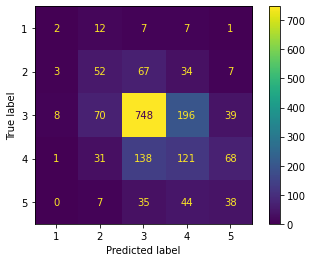

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(results['true_score'], results['predicted_score'])

Classification Report

In [74]:
from sklearn.metrics import classification_report
clr = classification_report(results['true_score'], results['predicted_score'])
print(clr)

              precision    recall  f1-score   support

           1       0.14      0.07      0.09        29
           2       0.30      0.32      0.31       163
           3       0.75      0.70      0.73      1061
           4       0.30      0.34      0.32       359
           5       0.25      0.31      0.27       124

    accuracy                           0.55      1736
   macro avg       0.35      0.35      0.34      1736
weighted avg       0.57      0.55      0.56      1736



The evaluation metrics show that this model has done a pretty poor job at classifying the sentiments of tweets for self-driving cars. The precision, recall, and f1-scores are all lower than 0.5 except for a prediction of 3. The confusion matrix also shows that the model correctly guesses tweet sentiments with sentiment of 3 most often.

This is most likely due to the fact that there are much more tweets that are labeled with a score of 3 compared to other scores in our training data. To improve, we would need to add more tweet data for the other sentiment scores. Also, it could be useful to use another prediction model, such as deep learning. We could also do further data cleaning to get rid of other unnecessary words. 